In [44]:
# Importation des modules

import pandas as pd
from gensim.models import Word2Vec
import random
import matplotlib.pyplot as plt
import numpy as np

#Affichage de toutes les colonnes

pd.set_option('display.max_columns', 500)

In [4]:
df_novice = pd.read_csv('results/embeddings_novice.csv')

df_exp = pd.read_csv('results/embeddings_exp.csv')

In [7]:
w2v_model_novice = Word2Vec.load("results/word2vec_novice.model")

w2v_model_exp = Word2Vec.load("results/word2vec_exp.model")

In [12]:
def overlap(model1, model2, n , word):
    neighborhood_1 = set([i[0] for i in model1.wv.most_similar(positive=[word], topn = n)])
    neighborhood_2 = set([i[0] for i in model2.wv.most_similar(positive=[word], topn = n)])

    return len(neighborhood_1.intersection(neighborhood_2))

In [35]:
words_common = list(set(df_novice['word']).intersection(set(df_exp['word'])))
random.shuffle(words_common)

/Users/lilianmarey/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lilianmarey/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


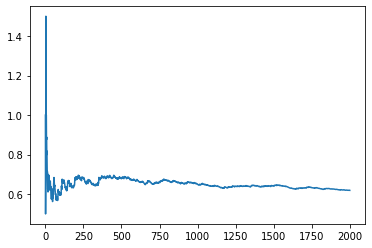

In [55]:
L_10 = [overlap(w2v_model_novice, w2v_model_exp, 10, word) for word in words_common]
plt.plot([np.mean(L_10[:i]) for i in range(2000)])

/Users/lilianmarey/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lilianmarey/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


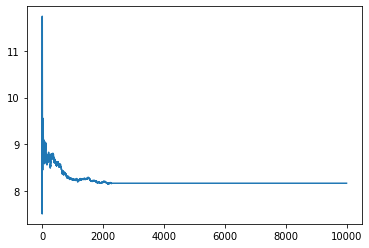

In [52]:
L_100 = [overlap(w2v_model_novice, w2v_model_exp, 100, word) for word in words_common]
plt.plot([np.mean(L_100[:i]) for i in range(10000)])

/Users/lilianmarey/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lilianmarey/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


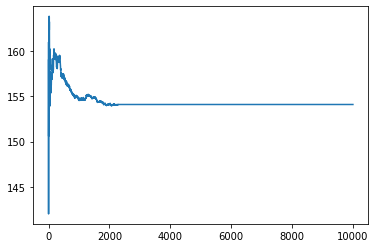

In [56]:
L_1000 = [overlap(w2v_model_novice, w2v_model_exp, 1000, word) for word in words_common]
plt.plot([np.mean(L_1000[:i]) for i in range(10000)])

In [127]:
def rank(model, i, j):
    
    k = -1
    K = 10
    
    while k == -1:
        neighborhood = [i[0] for i in model.wv.most_similar(positive=[i], topn = K)]
        try:
            k = neighborhood.index(j)
        except:
            k = -1
            
        K *= 10
            
    return k

def spread(model1, model2, n, word):
    neighborhood_1 = [i[0] for i in model1.wv.most_similar(positive=[word], topn = n)]
    ranks = [rank(model2, word, j) for j in neighborhood_1]
    return max(ranks)

In [128]:
spread(w2v_model_novice, w2v_model_exp, 13, 'droite')

793

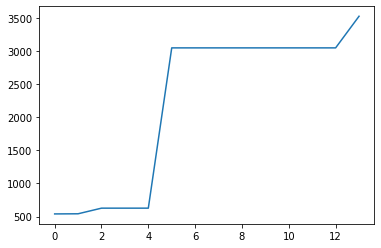

In [129]:
plt.plot([spread(w2v_model_novice, w2v_model_exp, i, 'demain') for i in range(1,15)])

In [130]:
plt.plot([spread(w2v_model_novice, w2v_model_exp, 6, word) for word in words_common[:10]])

KeyboardInterrupt: 